In [1]:
"""
04_process_res_generation_data.py - Process raw renewable energy sources (RES) generation data for Italy

This script processes raw RES generation data for Italy:
- Loads raw data from data/raw/res_generation/Italy/RES_generation20XX.csv (2015–2024)
- Cleans and standardizes the data format
- Combines relevant renewable generation columns (Solar, Wind, Hydro, etc.)
- Aggregates hourly data to daily total RES generation
- Handles missing values and outliers
- Saves processed data to data/processed/Italy/res_generation20XX_p.csv
- Concatenates all years and saves to data/final/Italy/res_generation2015_2024.csv
- Generates statistics and diagnostic plots
"""

'\n04_process_res_generation_data.py - Process raw renewable energy sources (RES) generation data for Italy\n\nThis script processes raw RES generation data for Italy:\n- Loads raw data from data/raw/res_generation/Italy/RES_generation20XX.csv (2015–2024)\n- Cleans and standardizes the data format\n- Combines relevant renewable generation columns (Solar, Wind, Hydro, etc.)\n- Aggregates hourly data to daily total RES generation\n- Handles missing values and outliers\n- Saves processed data to data/processed/Italy/res_generation20XX_p.csv\n- Concatenates all years and saves to data/final/Italy/res_generation2015_2024.csv\n- Generates statistics and diagnostic plots\n'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import datetime as dt

In [3]:
# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

In [4]:
# Define paths
BASE_DIR = Path(os.getcwd()).parent
RAW_DIR = BASE_DIR / 'data/raw/res_generation/Italy'
PROCESSED_DIR = BASE_DIR / 'data/processed/Italy'
FINAL_DIR = BASE_DIR / 'data/final/Italy'
IMAGES_DIR = BASE_DIR / 'outputs/images'

In [5]:
# Create directories if they don't exist
PROCESSED_DIR.mkdir(exist_ok=True, parents=True)
FINAL_DIR.mkdir(exist_ok=True, parents=True)
IMAGES_DIR.mkdir(exist_ok=True, parents=True)

In [6]:
def load_and_process_year(year):
    """Load and process a single year's RES generation data"""
    file_path = RAW_DIR / f'RES_generation{year}.csv'
    print(f"Processing {file_path}...")
    
    if not file_path.exists():
        print(f"File not found: {file_path}")
        return None
    
    # Load the data
    df = pd.read_csv(file_path)
    
    # Extract datetime from MTU column (format: "01.01.2015 00:00 - 01.01.2015 01:00 (CET/CEST)")
    df['datetime'] = df['MTU'].str.split(' - ').str[0]
    df['datetime'] = pd.to_datetime(df['datetime'], format='%d.%m.%Y %H:%M')
    
    # Define RES columns to process
    res_columns = [
        'Solar - Actual Aggregated [MW]',
        'Wind Offshore - Actual Aggregated [MW]',
        'Wind Onshore - Actual Aggregated [MW]',
        'Hydro Run-of-river and poundage - Actual Aggregated [MW]',
        'Hydro Water Reservoir - Actual Aggregated [MW]',
        'Biomass - Actual Aggregated [MW]',
        'Geothermal - Actual Aggregated [MW]',
        'Other renewable - Actual Aggregated [MW]'
    ]
    
    # Replace 'n/e' (not existing) and 'N/A' values with NaN
    for col in res_columns:
        if col in df.columns:
            df[col] = df[col].replace(['n/e', 'N/A'], np.nan)
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Create combined RES generation column
    df['total_res_mw'] = 0
    for col in res_columns:
        if col in df.columns:
            df['total_res_mw'] += df[col].fillna(0)
    
    # Create individual generation columns with standardized names
    if 'Solar - Actual Aggregated [MW]' in df.columns:
        df['solar_mw'] = df['Solar - Actual Aggregated [MW]'].fillna(0)
    else:
        df['solar_mw'] = 0
        
    # Combine offshore and onshore wind
    df['wind_mw'] = 0
    if 'Wind Offshore - Actual Aggregated [MW]' in df.columns:
        df['wind_mw'] += df['Wind Offshore - Actual Aggregated [MW]'].fillna(0)
    if 'Wind Onshore - Actual Aggregated [MW]' in df.columns:
        df['wind_mw'] += df['Wind Onshore - Actual Aggregated [MW]'].fillna(0)
    
    # Combine hydro sources
    df['hydro_mw'] = 0
    if 'Hydro Run-of-river and poundage - Actual Aggregated [MW]' in df.columns:
        df['hydro_mw'] += df['Hydro Run-of-river and poundage - Actual Aggregated [MW]'].fillna(0)
    if 'Hydro Water Reservoir - Actual Aggregated [MW]' in df.columns:
        df['hydro_mw'] += df['Hydro Water Reservoir - Actual Aggregated [MW]'].fillna(0)
    
    # Other RES sources
    if 'Biomass - Actual Aggregated [MW]' in df.columns:
        df['biomass_mw'] = df['Biomass - Actual Aggregated [MW]'].fillna(0)
    else:
        df['biomass_mw'] = 0
        
    if 'Geothermal - Actual Aggregated [MW]' in df.columns:
        df['geothermal_mw'] = df['Geothermal - Actual Aggregated [MW]'].fillna(0)
    else:
        df['geothermal_mw'] = 0
    
    # Extract date component for daily aggregation
    df['date'] = df['datetime'].dt.date
    
    # Aggregate to daily values
    # For generation, we want the average power throughout the day
    daily = df.groupby('date').agg({
        'total_res_mw': 'mean',
        'solar_mw': 'mean',
        'wind_mw': 'mean',
        'hydro_mw': 'mean',
        'biomass_mw': 'mean',
        'geothermal_mw': 'mean'
    }).reset_index()
    
    # Convert date to datetime
    daily['date'] = pd.to_datetime(daily['date'])
    
    # Outlier detection using IQR method
    Q1 = daily['total_res_mw'].quantile(0.25)
    Q3 = daily['total_res_mw'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    daily['is_outlier'] = (daily['total_res_mw'] < lower_bound) | (daily['total_res_mw'] > upper_bound)
    
    # Add year, month, day columns
    daily['year'] = daily['date'].dt.year
    daily['month'] = daily['date'].dt.month
    daily['day'] = daily['date'].dt.day
    
    # Save processed file
    out_path = PROCESSED_DIR / f'res_generation{year}_p.csv'
    daily.to_csv(out_path, index=False)
    print(f"Saved processed file: {out_path}")
    
    return daily

In [7]:
def generate_statistics_and_plots(df):
    """Generate statistics and plots for the processed data"""
    print("Generating statistics and plots...")
    
    # Basic statistics
    print("\nBasic Statistics for Total RES Generation:")
    print("-" * 40)
    print(df['total_res_mw'].describe())
    
    # Yearly averages
    print("\nYearly averages:")
    yearly_avg = df.groupby('year')[['total_res_mw', 'solar_mw', 'wind_mw', 'hydro_mw', 'biomass_mw', 'geothermal_mw']].mean()
    print(yearly_avg)
    
    # Monthly averages
    print("\nMonthly averages (across all years):")
    monthly_avg = df.groupby('month')[['total_res_mw', 'solar_mw', 'wind_mw', 'hydro_mw']].mean()
    print(monthly_avg)
    
    # Time series plot for total RES generation
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['total_res_mw'], color='green', alpha=0.7)
    plt.title('Daily Average RES Generation (2015-2024)')
    plt.xlabel('Date')
    plt.ylabel('Generation (MW)')
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'res_generation_timeseries.png', dpi=300)
    
    # Yearly boxplot
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='year', y='total_res_mw', data=df)
    plt.title('RES Generation Distribution by Year')
    plt.xlabel('Year')
    plt.ylabel('Generation (MW)')
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'yearly_res_distribution.png', dpi=300)
    
    # Monthly boxplot
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='month', y='total_res_mw', data=df)
    plt.title('RES Generation Distribution by Month')
    plt.xlabel('Month')
    plt.ylabel('Generation (MW)')
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'monthly_res_distribution.png', dpi=300)
    
    # Distribution plot
    plt.figure(figsize=(12, 6))
    sns.histplot(df['total_res_mw'], kde=True, bins=30, color='green')
    plt.title('RES Generation Distribution')
    plt.xlabel('Generation (MW)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'res_distribution.png', dpi=300)
    
    # Outlier plot
    if 'is_outlier' in df.columns and df['is_outlier'].sum() > 0:
        plt.figure(figsize=(12, 6))
        plt.scatter(df['date'], df['total_res_mw'], 
                   c=df['is_outlier'].map({True: 'red', False: 'green'}),
                   alpha=0.7)
        plt.title('RES Generation Outliers')
        plt.xlabel('Date')
        plt.ylabel('Generation (MW)')
        plt.tight_layout()
        plt.savefig(IMAGES_DIR / 'res_outliers.png', dpi=300)
    
    # Stacked area chart of generation sources
    plt.figure(figsize=(14, 8))
    df_plot = df.sort_values('date')
    plt.stackplot(df_plot['date'], 
                 df_plot['solar_mw'], 
                 df_plot['wind_mw'], 
                 df_plot['hydro_mw'],
                 df_plot['biomass_mw'],
                 df_plot['geothermal_mw'],
                 labels=['Solar', 'Wind', 'Hydro', 'Biomass', 'Geothermal'],
                 alpha=0.7)
    plt.title('RES Generation Mix (2015-2024)')
    plt.xlabel('Date')
    plt.ylabel('Generation (MW)')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'res_generation_mix.png', dpi=300)
    
    # Pie chart of average generation by source
    plt.figure(figsize=(10, 10))
    sources = ['Solar', 'Wind', 'Hydro', 'Biomass', 'Geothermal']
    values = [
        df['solar_mw'].mean(),
        df['wind_mw'].mean(),
        df['hydro_mw'].mean(),
        df['biomass_mw'].mean(),
        df['geothermal_mw'].mean()
    ]
    plt.pie(values, labels=sources, autopct='%1.1f%%', startangle=90, shadow=True)
    plt.axis('equal')
    plt.title('Average RES Generation Mix')
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'res_generation_pie.png', dpi=300)
    
    print(f"Plots saved to {IMAGES_DIR}")

Starting RES generation data processing...
Processing /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/raw/res_generation/Italy/RES_generation2015.csv...
Saved processed file: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/processed/Italy/res_generation2015_p.csv
Processing /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/raw/res_generation/Italy/RES_generation2016.csv...
Saved processed file: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/processed/Italy/res_generation2016_p.csv
Processing /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/raw/res_generation/Italy/RES_generation2017.csv...
Saved processed file: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/processed/Italy/res_generation2017_p.csv
Processing /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/raw/res_generation/Italy/RES_generation2018.csv...
Saved processed file: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/processed/

/var/folders/4y/dxs3znt16fgcsl556_td55sh0000gn/T/ipykernel_92742/2807277165.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(['n/e', 'N/A'], np.nan)
/var/folders/4y/dxs3znt16fgcsl556_td55sh0000gn/T/ipykernel_92742/2807277165.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(['n/e', 'N/A'], np.nan)
/var/folders/4y/dxs3znt16fgcsl556_td55sh0000gn/T/ipykernel_92742/2807277165.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future 

Saved processed file: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/processed/Italy/res_generation2020_p.csv
Processing /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/raw/res_generation/Italy/RES_generation2021.csv...
Saved processed file: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/processed/Italy/res_generation2021_p.csv
Processing /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/raw/res_generation/Italy/RES_generation2022.csv...
Saved processed file: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/processed/Italy/res_generation2022_p.csv
Processing /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/raw/res_generation/Italy/RES_generation2023.csv...
Saved processed file: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/processed/Italy/res_generation2023_p.csv
Processing /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/raw/res_generation/Italy/RES_generation2024.csv...
Saved proces

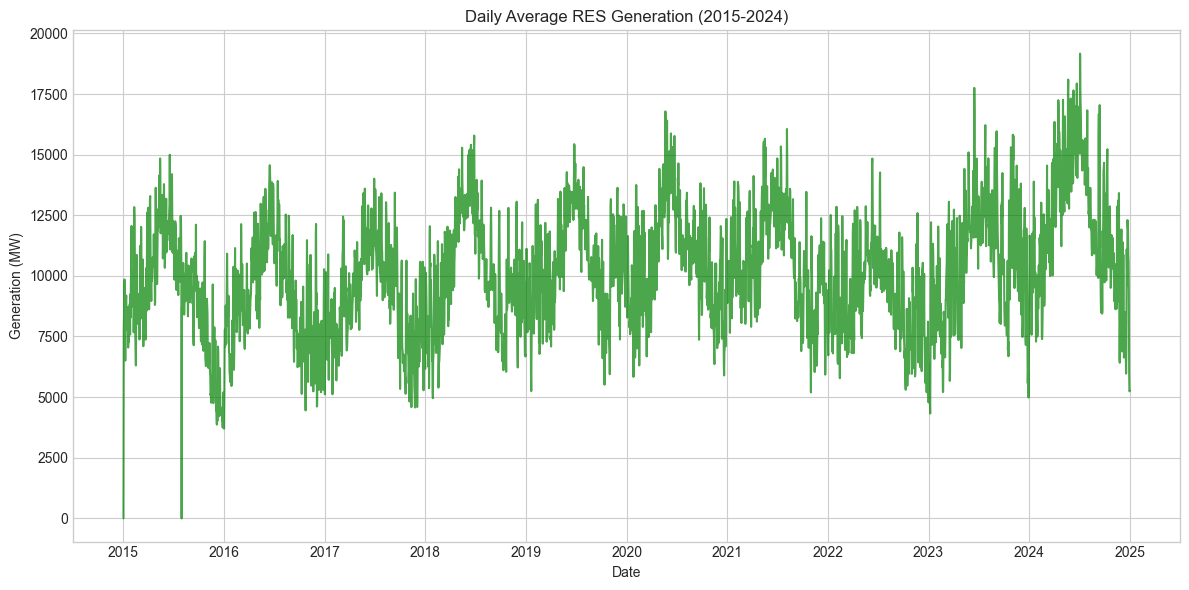

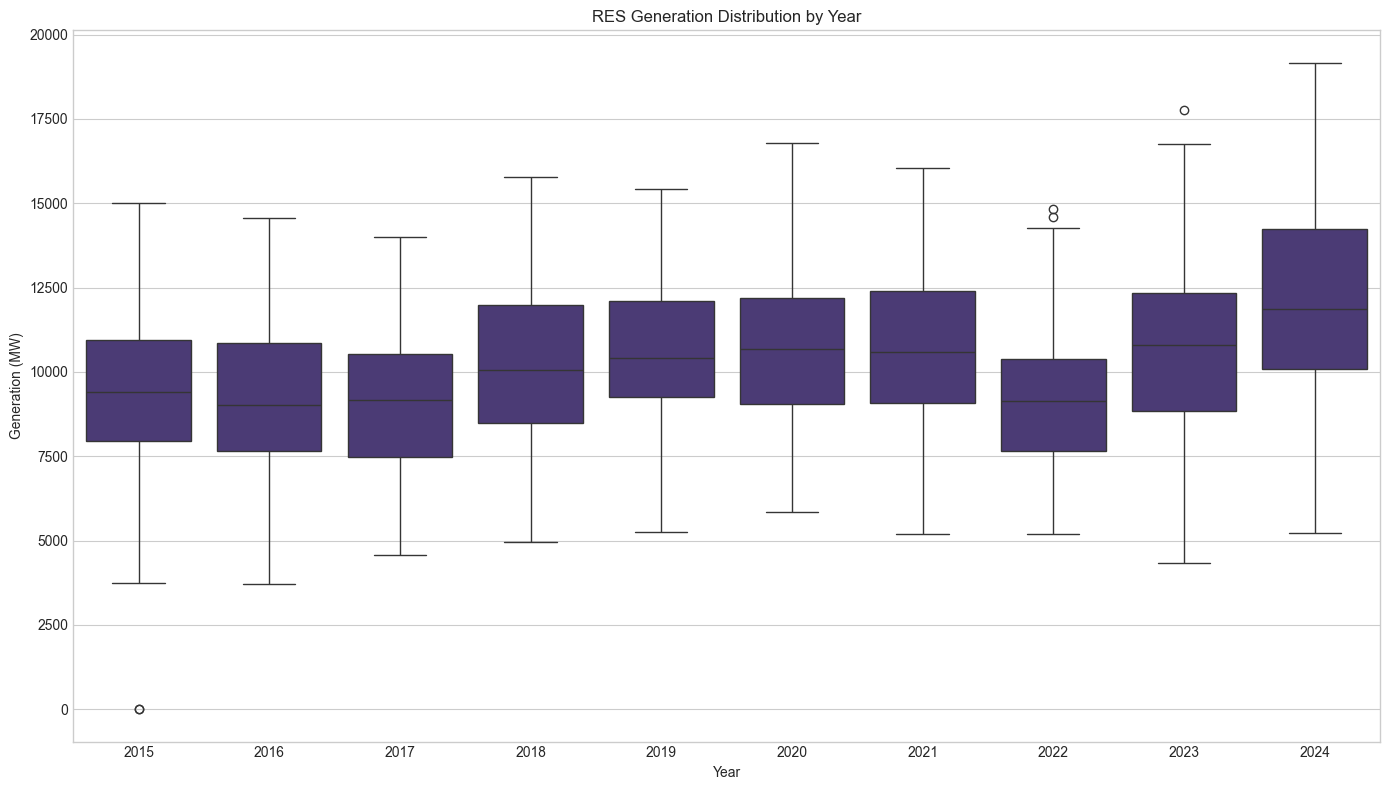

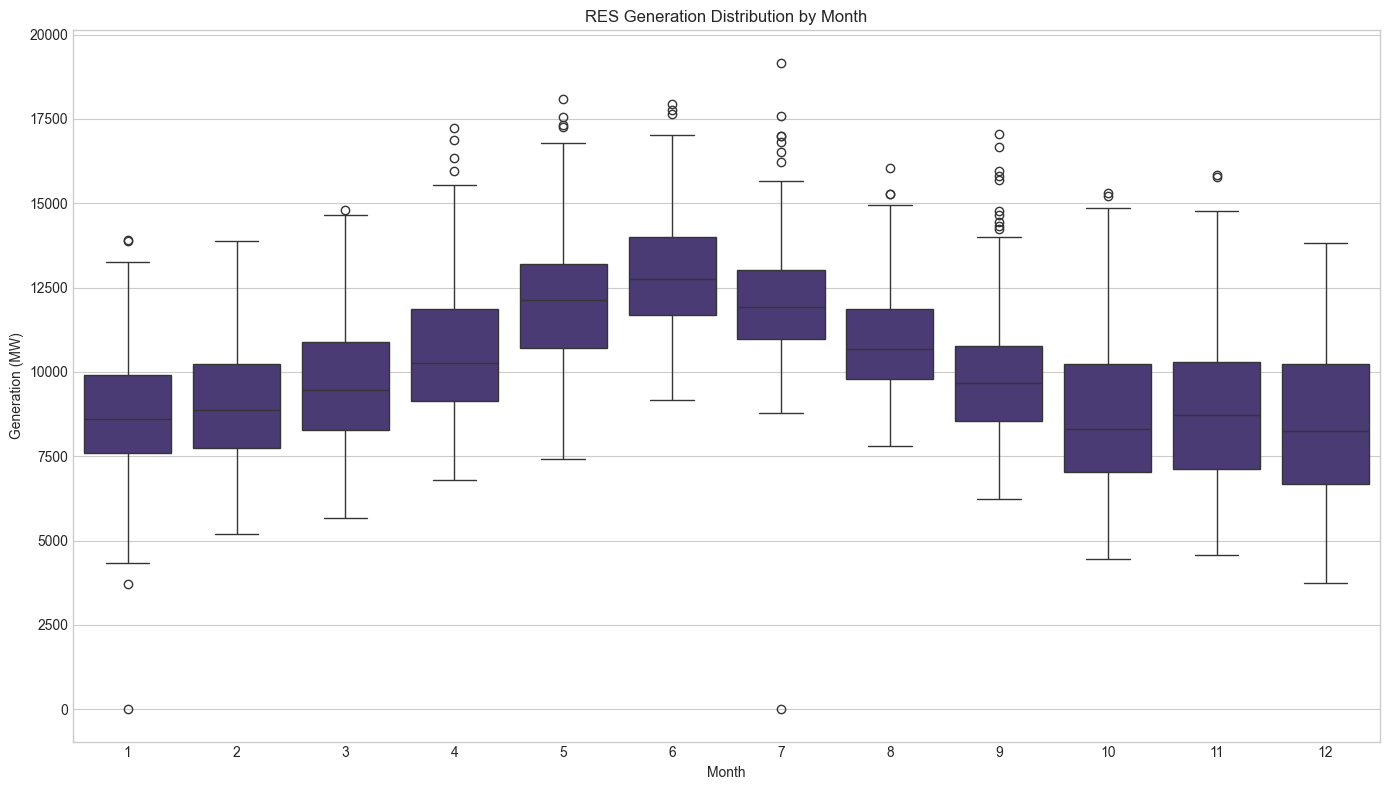

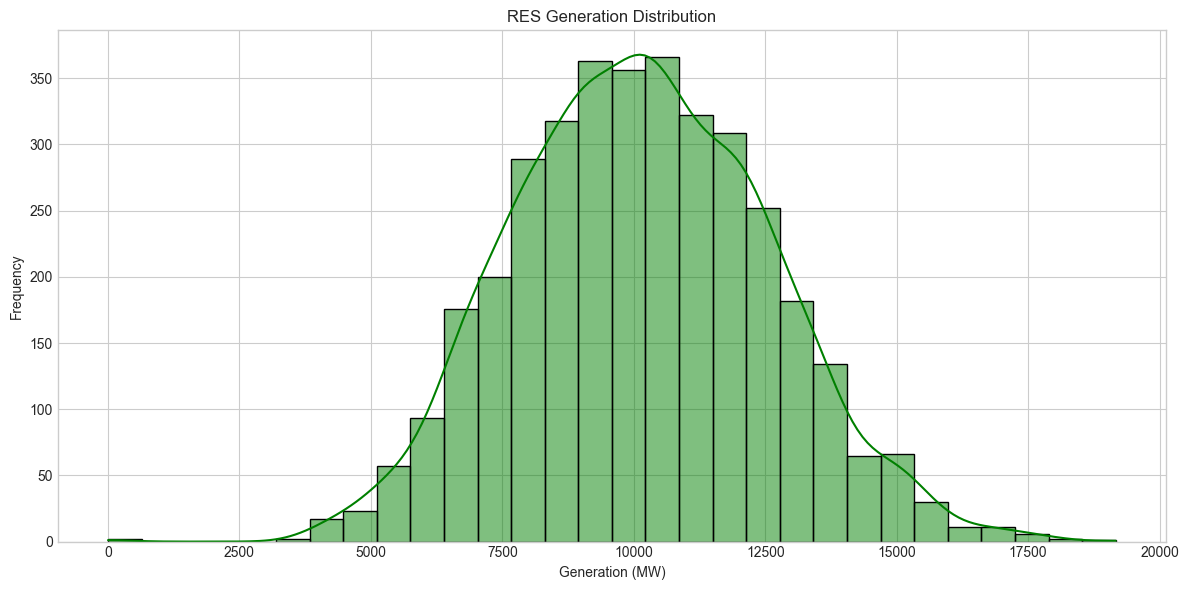

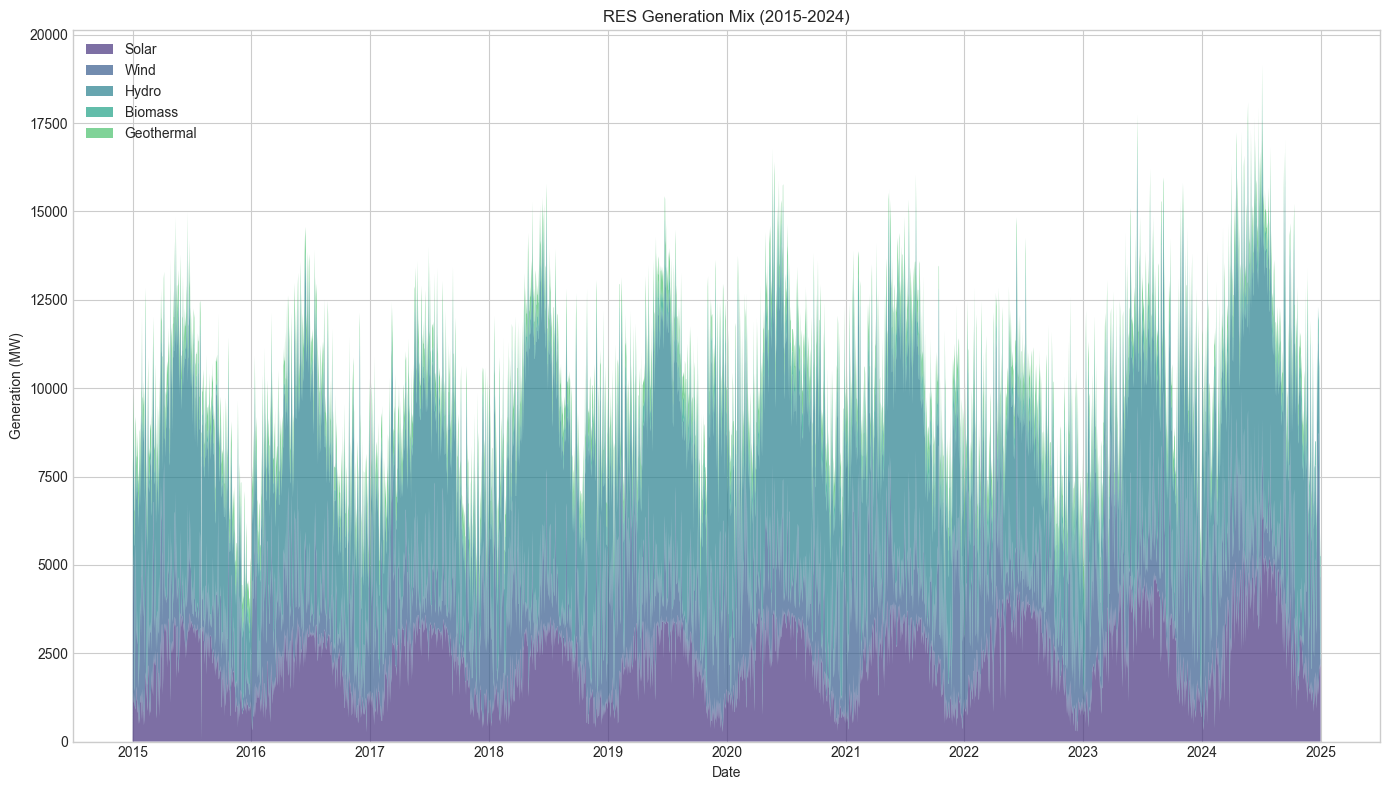

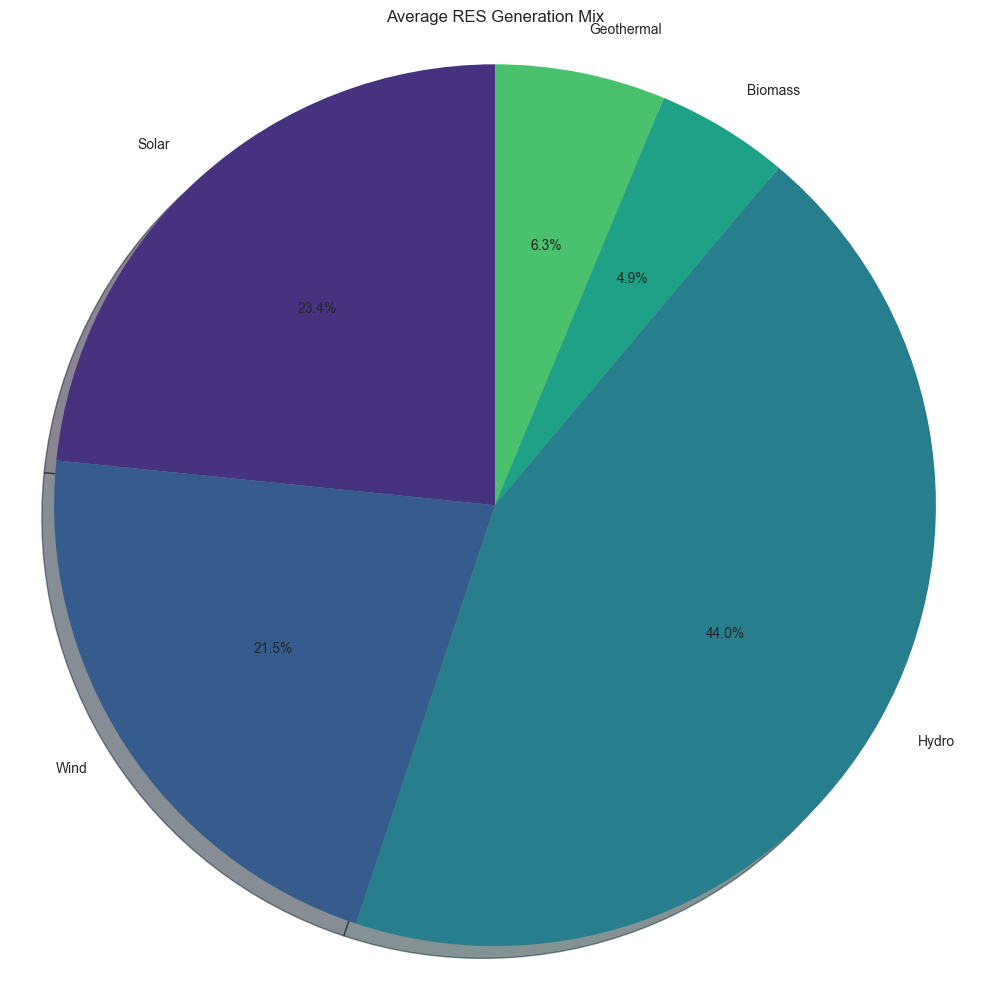

In [8]:
"""Main processing function"""
print("Starting RES generation data processing...")

all_years = []
for year in range(2015, 2025):
    daily = load_and_process_year(year)
    if daily is not None:
        all_years.append(daily)

if not all_years:
    print("No data processed.")
    

# Concatenate all years
df_all = pd.concat(all_years, ignore_index=True)
df_all = df_all.sort_values('date')

# Save concatenated data
concat_path = FINAL_DIR / 'res_generation2015_2024.csv'
df_all.to_csv(concat_path, index=False)
print(f"Saved concatenated RES generation data: {concat_path}")

# Try to merge with price data if available
price_path = PROCESSED_DIR / 'PUN_p.csv'
if price_path.exists():
    try:
        price_df_full = pd.read_csv(price_path) # Load the full price dataframe

        # --- START MODIFICATION: Select only necessary columns from price_df_full ---
        price_date_col_name = 'Date' if 'Date' in price_df_full.columns else 'date'
        
        cols_from_price_to_merge = [price_date_col_name]
        
        # Find the price_eur_mwh column, handling potential case variations or exact name
        price_eur_mwh_col_actual = None
        if 'price_eur_mwh' in price_df_full.columns:
            price_eur_mwh_col_actual = 'price_eur_mwh'
        else:
            for col in price_df_full.columns: # Fallback for case insensitivity or slight variations
                if 'price_eur_mwh' == col.lower():
                    price_eur_mwh_col_actual = col
                    break
        
        if price_eur_mwh_col_actual:
            cols_from_price_to_merge.append(price_eur_mwh_col_actual)
        else:
            print(f"Warning: 'price_eur_mwh' column not found in {price_path}. Price will not be merged.")
            # If price_eur_mwh is critical and not found, you might choose to skip merging or raise an error.
            # For now, it will proceed without the price column if not found.

        # Create a subset of price_df with only the date and price_eur_mwh columns
        # Also ensure no other columns from price_df_full are accidentally pulled in.
        if price_eur_mwh_col_actual: # Proceed only if price column was found
            price_df_subset = price_df_full[cols_from_price_to_merge].copy()
            
            # Standardize date column in the subset
            price_df_subset[price_date_col_name] = pd.to_datetime(price_df_subset[price_date_col_name])
            
            # Standardize RES data date column
            df_all['date'] = pd.to_datetime(df_all['date'])
            
            # Merge on date using the subset of price data
            merged = pd.merge(df_all, price_df_subset, 
                                left_on='date', 
                                right_on=price_date_col_name, # Use the original date column name from price_df for merge
                                how='left', 
                                suffixes=('_res', '_price')) # Suffixes will apply if there's an unexpected name clash

            # If the price_date_col_name was different from 'date' (e.g., 'Date')
            # and you want to drop the redundant date column from price_df_subset after merge:
            if price_date_col_name in merged.columns and price_date_col_name != 'date':
                merged.drop(columns=[price_date_col_name], inplace=True)

        else: # price_eur_mwh column was not found in price_df_full
            print("Skipping merge with price data as 'price_eur_mwh' column was not identified.")
            merged = df_all.copy() # Proceed with just the RES data

        # --- END MODIFICATION ---
        
        # Save merged data
        merged_path = FINAL_DIR / 'res_generation2015_2024_merged.csv'
        merged.to_csv(merged_path, index=False)
        print(f"Saved merged RES-price data to: {merged_path} (Columns: {merged.columns.tolist()})")
    except Exception as e:
        print(f"Error merging with price data: {e}")
        # If merge fails, save the unmerged df_all to the target filename to avoid breaking downstream scripts
        # that expect this file.
        merged_path = FINAL_DIR / 'res_generation2015_2024_merged.csv'
        df_all.to_csv(merged_path, index=False)
        print(f"Saved unmerged RES data to {merged_path} due to merge error.")
        raise
else:
    print(f"Price data not found at {price_path}, saving RES data without merging price.")
    # If price file doesn't exist, save the unmerged df_all to the target filename
    merged_path = FINAL_DIR / 'res_generation2015_2024_merged.csv'
    df_all.to_csv(merged_path, index=False)
    print(f"Saved RES data (unmerged) to {merged_path}")
    

# Generate statistics and plots
generate_statistics_and_plots(df_all)
print("RES generation data processing complete!")